### Process and Visualize IWG data from Arctic Heat

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os

In [70]:
source_dir = '/Users/bell/ecoraid/2018/Additional_FieldData/ArcticHeat/IWG_data/'
source_file = source_dir + '20180525_221008_IWG.clean.dat'

In [94]:
source_file = [x for x in os.listdir(source_dir) if x.endswith('.clean.dat')]

In [95]:
columns = ['IWG1_NAMES','TIME','LAT','LON','ALTGPS','GPS_GEOIDHT','ALTPAFT',
           'ALTRAFT','GS','TAS','IAS','MACH','GSZ','THDG','TRK','DA','PITCH','ROLL',
           'SA','AA','TA','TD','TTM','PS','PQ','PCAB','WS','WD','UWZ','none1','none2',
           'none3','none4','FLID','MISSIONID','STORMID','SST','PYRAUCLEAR','RH']

In [104]:
dfs = {}

In [107]:
for i,filename in enumerate(source_file):
    print(filename)
    dfs.update({filename:pd.read_csv(source_dir + filename,delimiter=',')})

20180527_210946_IWG.clean.dat
20180525_221008_IWG.clean.dat


In [113]:
for file in dfs.keys():
    print(dfs[file].head())

  IWG1_NAMES             TIME        LAT         LON  ALTGPS  GPS_GEOIDHT  \
0       IWG1  20180527T214628   0.000000    0.000000       0          NaN   
1       IWG1  20180527T214629   0.000000    0.000000       0          NaN   
2       IWG1  20180527T214630  66.890594 -162.607437       1          NaN   
3       IWG1  20180527T214631  66.890594 -162.607437       1          NaN   
4       IWG1  20180527T214632  66.890594 -162.607437       1          NaN   

   ALTPAFT  ALTRAFT   GS   TAS  ...   none  none.1  none.2  none.3  \
0        0      -20  0.0  9.59  ...    NaN     NaN     NaN     NaN   
1     -100        4  0.0  9.59  ...    NaN     NaN     NaN     NaN   
2     -100        4  0.0  9.59  ...    NaN     NaN     NaN     NaN   
3     -100        4  0.0  9.60  ...    NaN     NaN     NaN     NaN   
4     -100        3  0.0  9.66  ...    NaN     NaN     NaN     NaN   

         FLID    MISSIONID  STORMID    SST  PYRAUCLEAR    RH  
0  20180527L1  ARCTIC_HEAT      NaN -21.03       -0.0

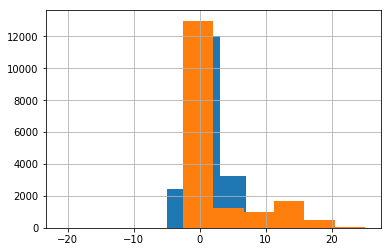

In [114]:
for file in dfs.keys():
    dfs[file]['SST'].hist()

In [75]:
import gmt

In [123]:
fig = gmt.Figure()

fig.coast(region=[-170, -160, 66, 71], projection='B-160/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

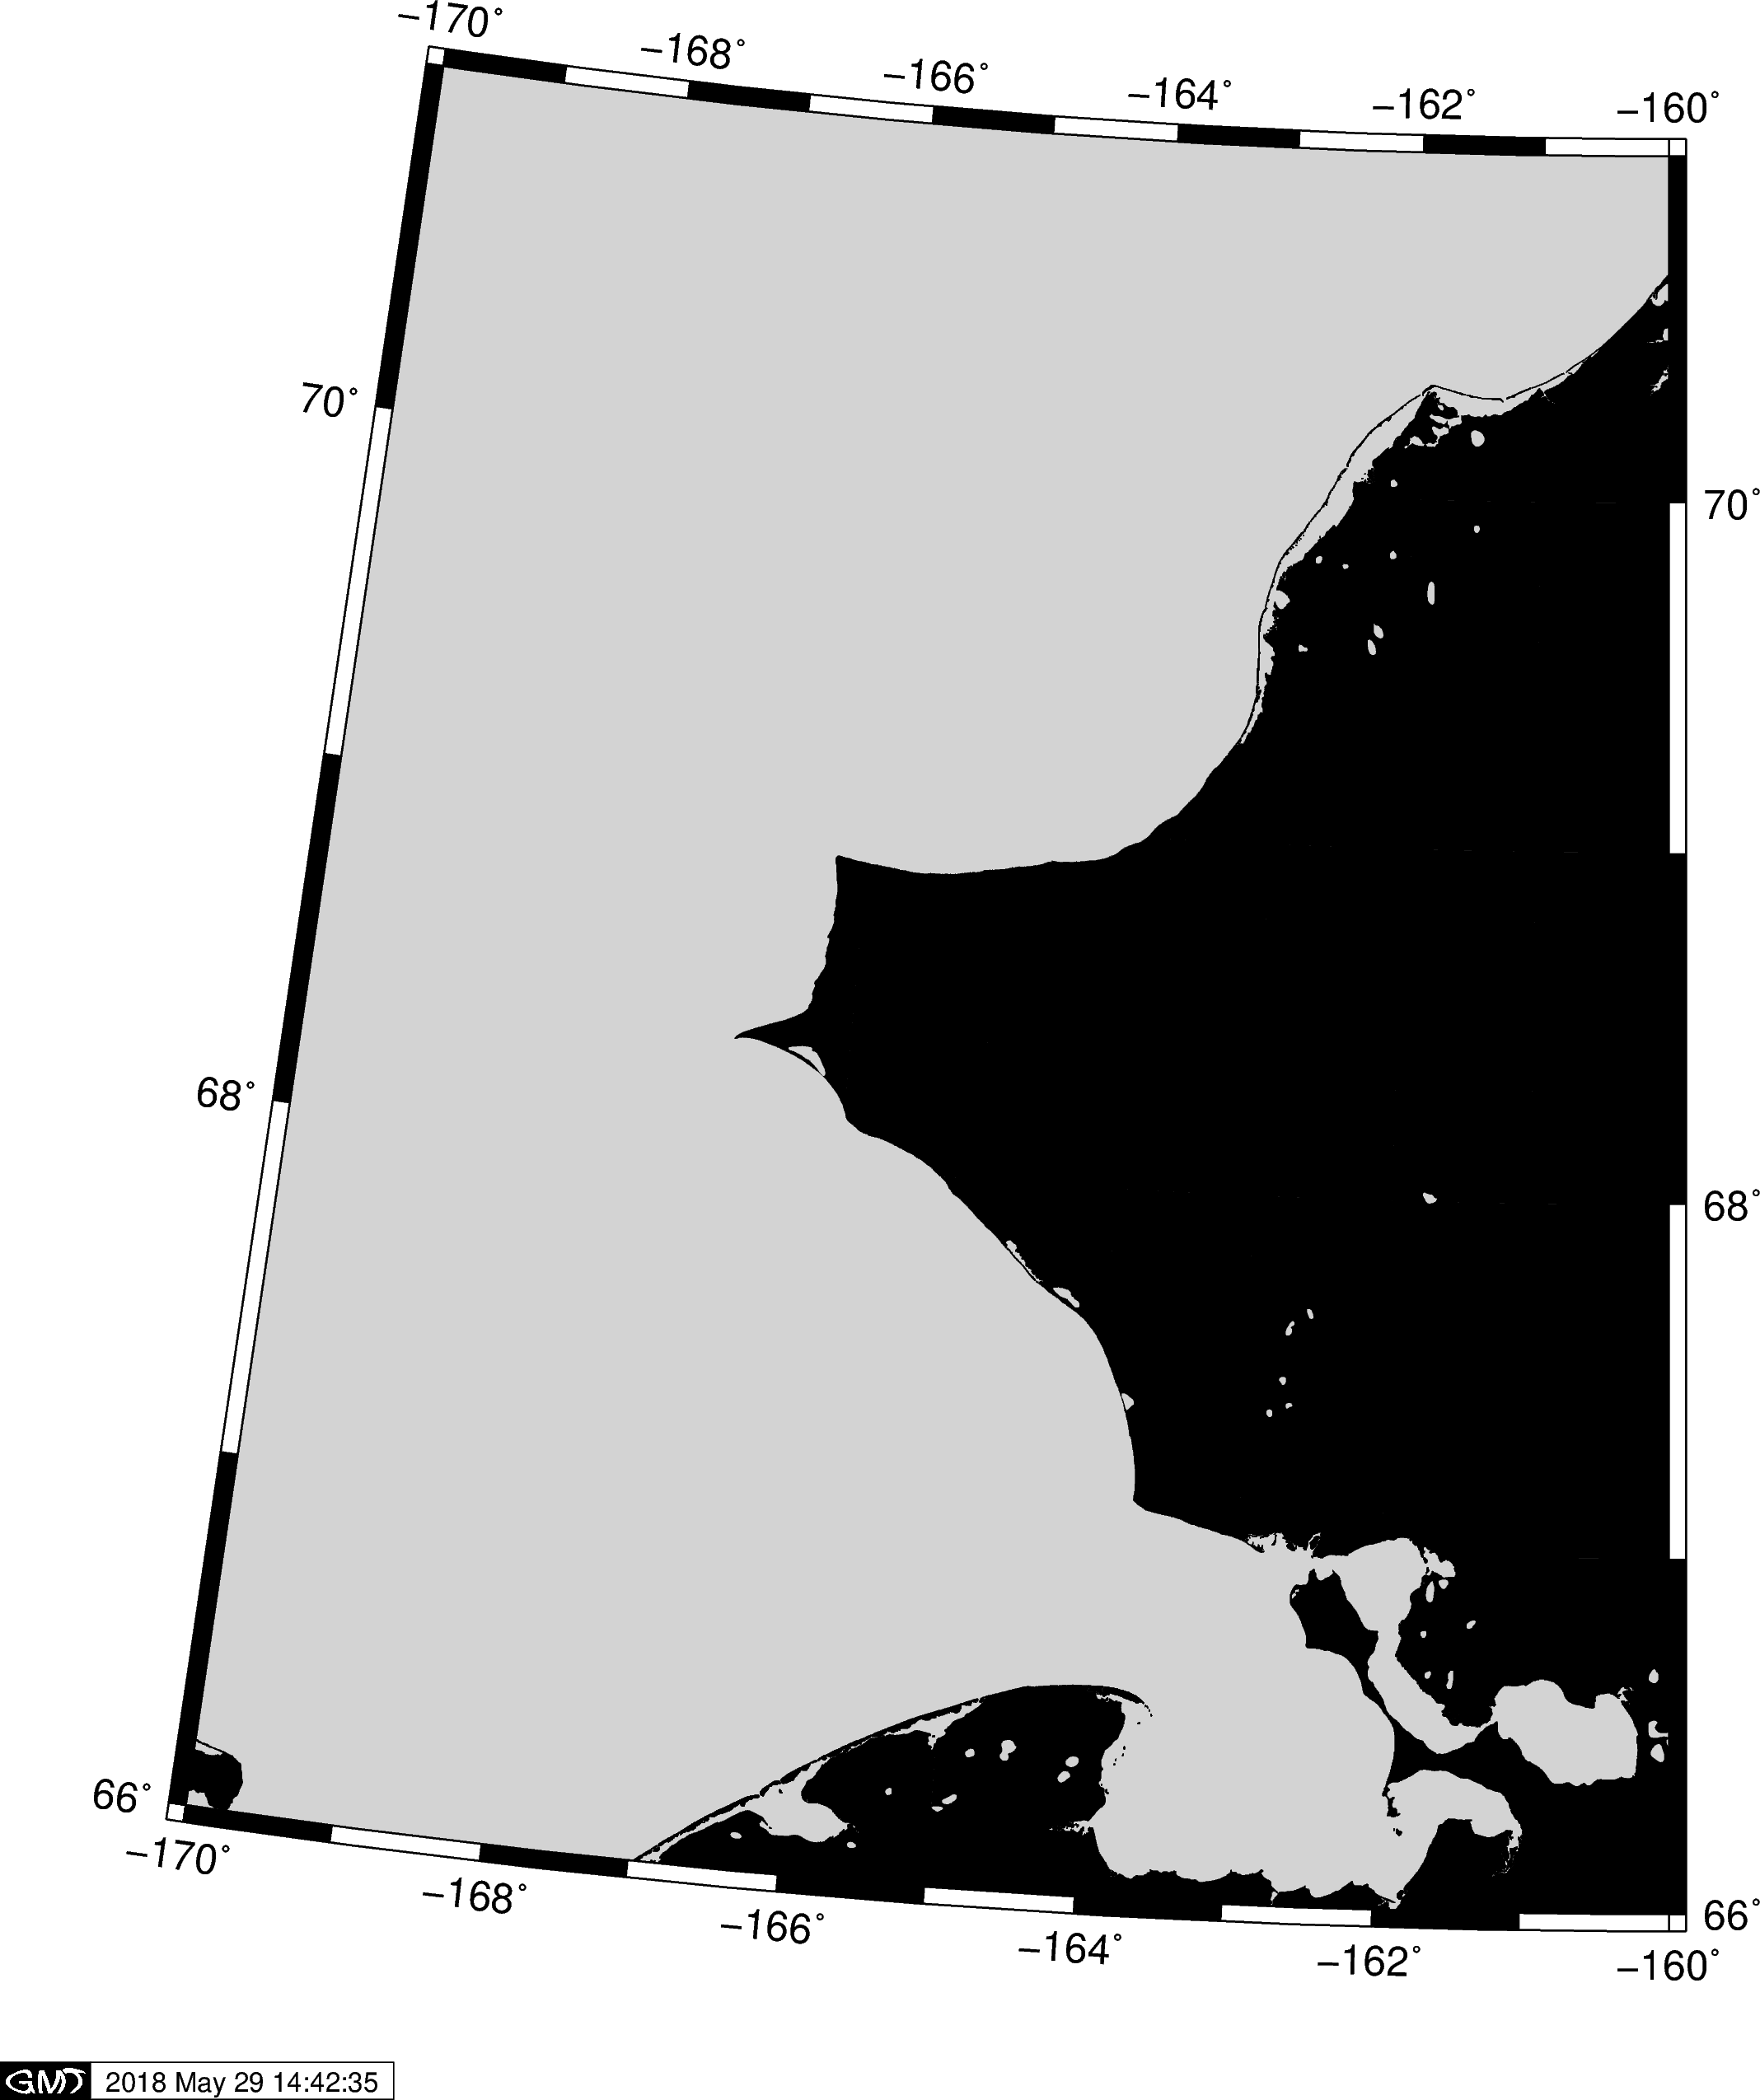

In [124]:
fig.show()

In [125]:
#choose temp boundaries
upper_limit = 5
lower_limit = -2

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['SST'].loc[(dfs[file]['SST'] > upper_limit ) | (dfs[file]['SST'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['SST'].apply(lambda x: (x - (lower_limit)) / (upper_limit - (lower_limit)))
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=256*dfnorm, cmap='thermal', style='c0.05c')


/Users/bell/anaconda2/envs/gmt-python/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


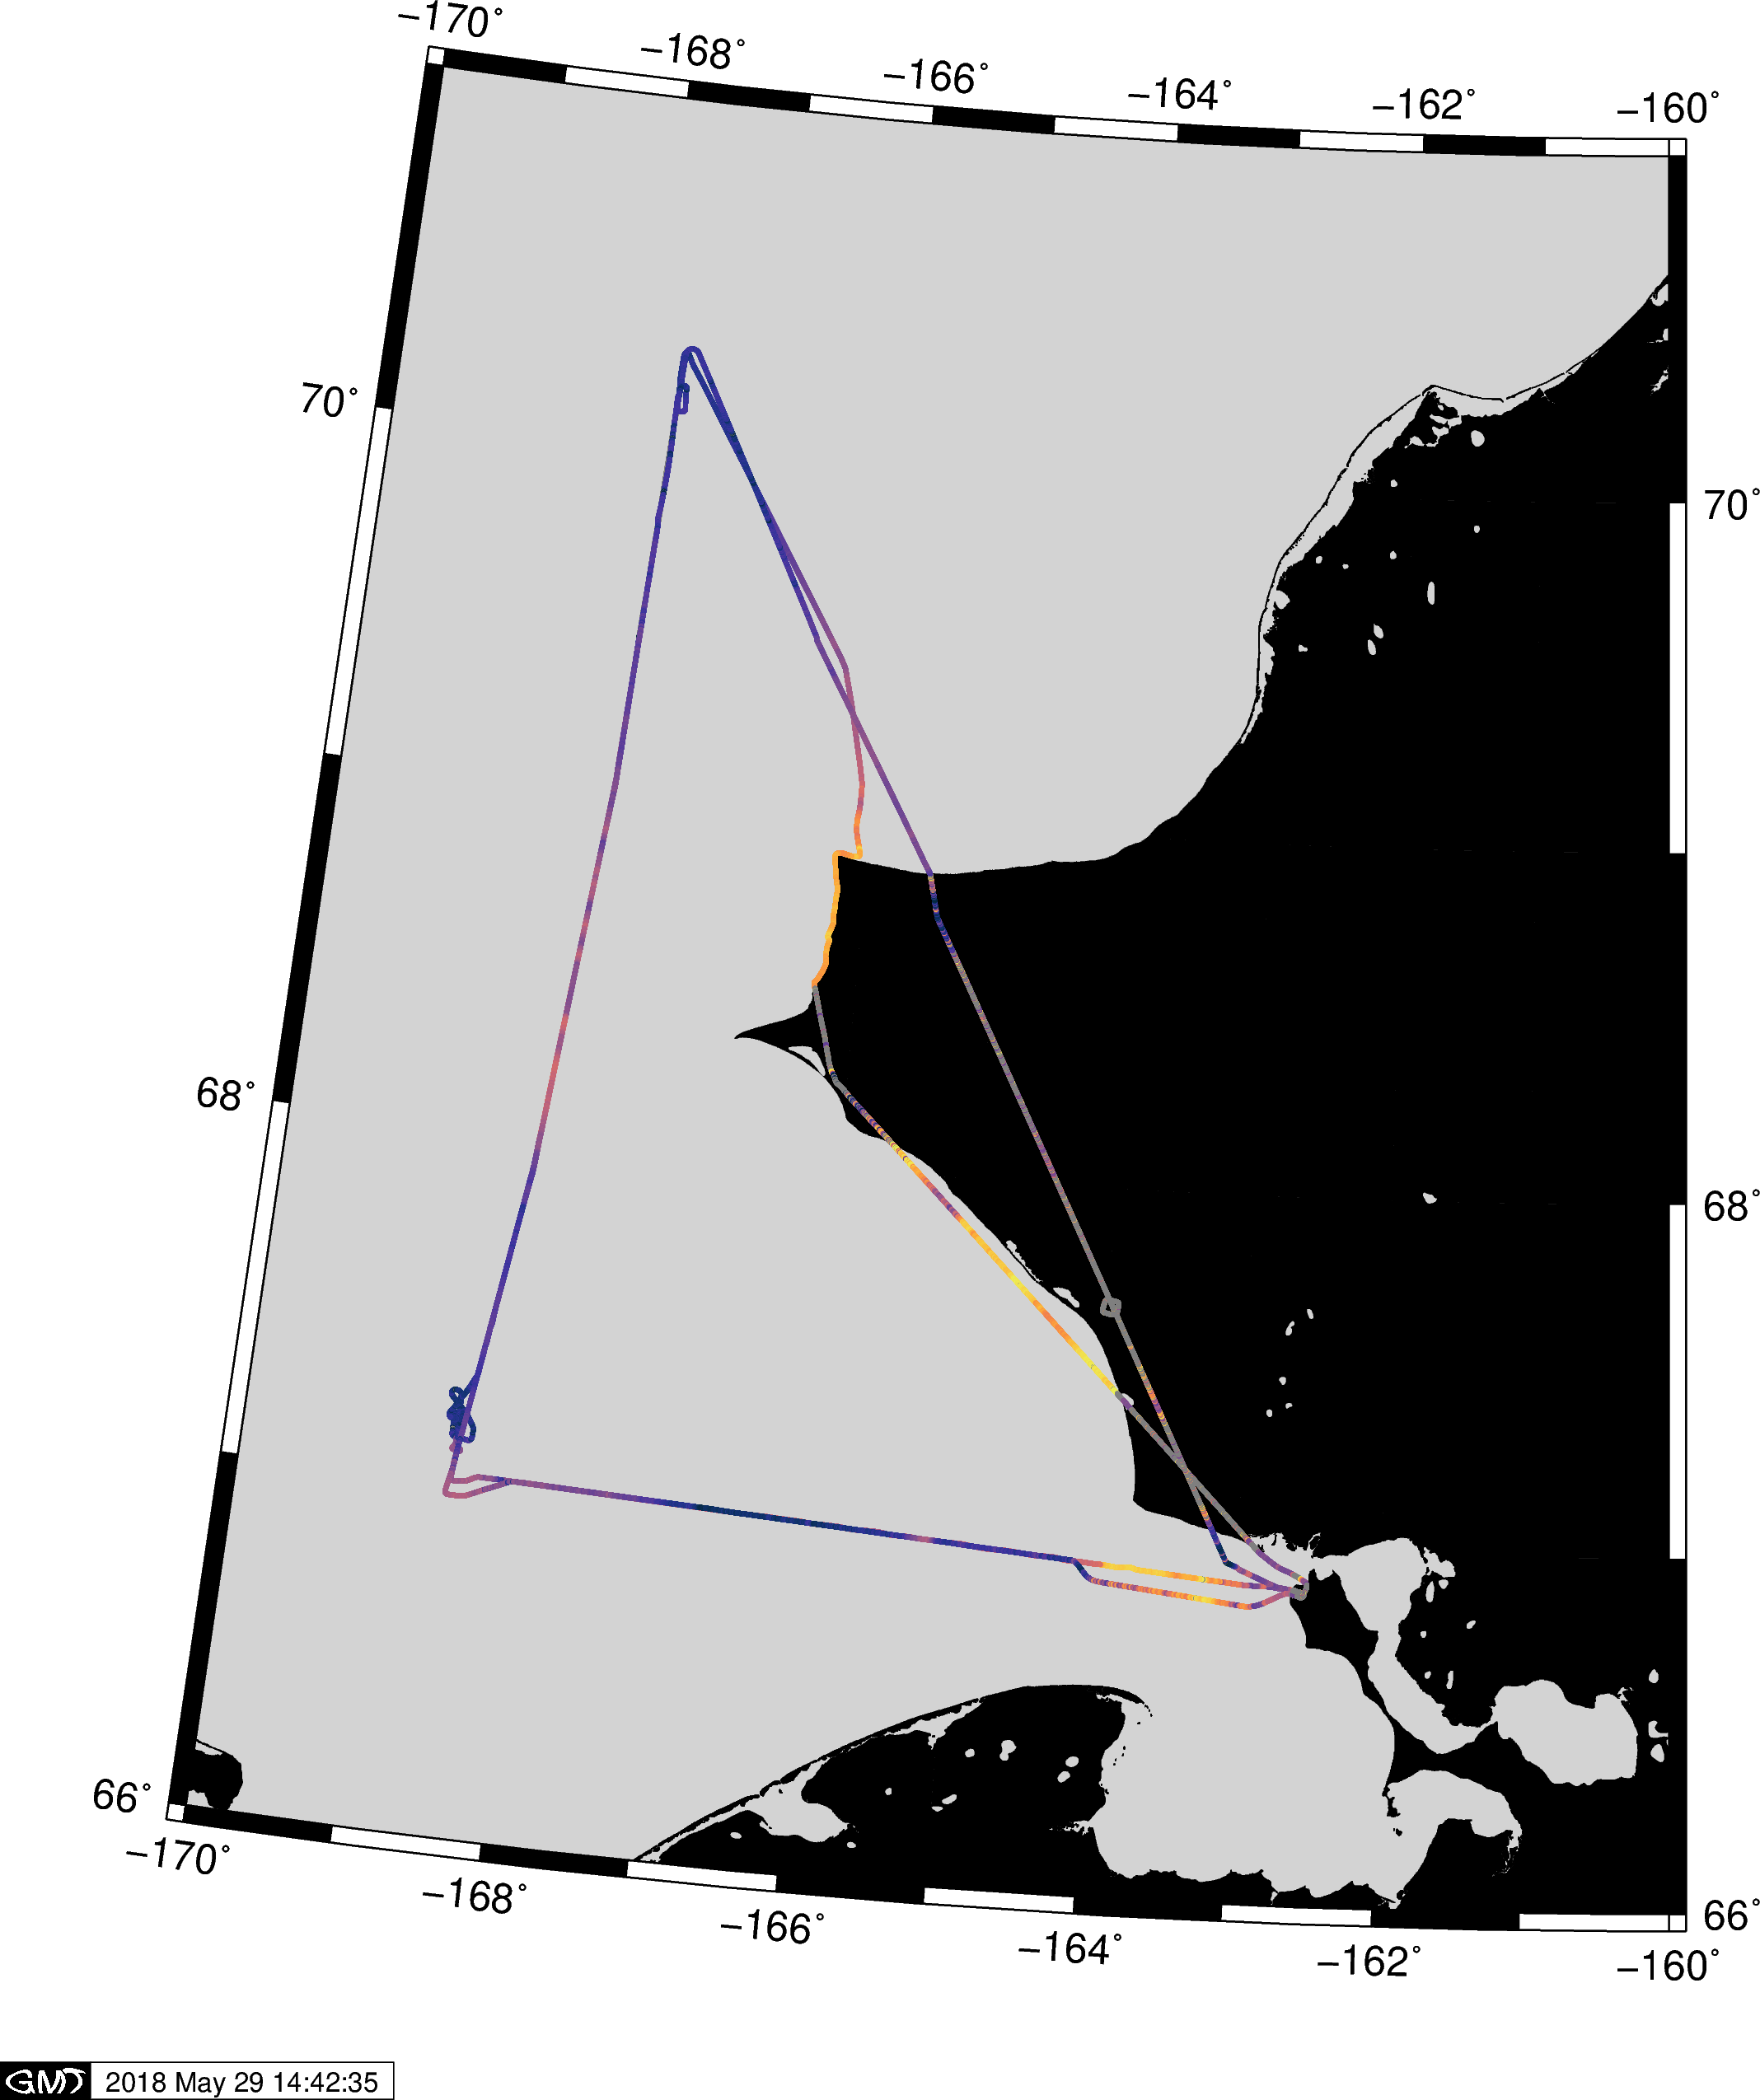

In [126]:
fig.show()

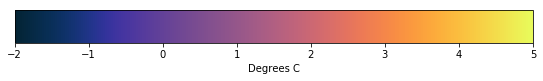

In [80]:

'''
====================
Customized colorbars
====================

This example shows how to build colorbars without an attached mappable.
'''

import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = cmocean.cm.thermal
norm = mpl.colors.Normalize(vmin=lower_limit, vmax=upper_limit)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Degrees C')

# The second example illustrates the use of a ListedColormap, a
# BoundaryNorm, and extended ends to show the "over" and "under"
# value colors.
cmap = mpl.colors.ListedColormap(['r', 'g', 'b', 'c'])
cmap.set_over('0.25')
cmap.set_under('0.75')

plt.show()